In [116]:
from functools import partial
import os

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [117]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
#import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
#from keras import backend, optimizers

In [118]:
# force channels-first ordering for all loaded images
#backend.set_image_data_format('channels_last')  #The models are designed to use channels first

image_directory = "/kaggle/input/cleaned-dataset/Base_donnees/Images/"
mask_directory = "/kaggle/input/cleaned-dataset/Base_donnees/Masks/"

In [119]:
SIZE = 128
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


In [120]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'jpg'):
        # print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [121]:
#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [122]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

In [124]:
X_train.shape

(1770, 128, 128, 3)

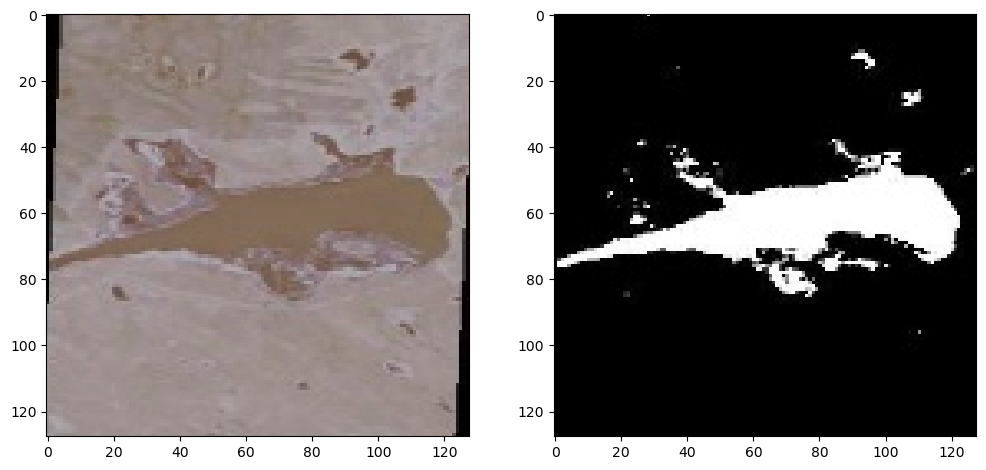

In [125]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128, 3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

In [126]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8
#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
#from focal_loss import BinaryFocalLoss

In [127]:
!pip install keras-unet-collection

In [128]:
from keras_unet_collection import models, losses

In [129]:
#Model 1: Unet with ImageNet trained VGG16 backbone
#help(models.att_unet_2d)

In [130]:
model_att_unet = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           atten_activation='ReLU', attention='add', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

/opt/conda/lib/python3.10/site-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


In [131]:
model_att_unet.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-4), 
              metrics=['accuracy', losses.dice_coef, losses.iou_seg])

In [132]:
#print(model_Unet.summary())

In [133]:
start1 = datetime.now() 
att_unet_history = model_att_unet.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=30)
stop1 = datetime.now()

Epoch 1/30
222/222 [==============================] - 50s 147ms/step - loss: 0.3199 - accuracy: 0.6839 - dice_coef: 0.6883 - iou_seg: 0.4655 - val_loss: 0.2407 - val_accuracy: 0.7263 - val_dice_coef: 0.7521 - val_iou_seg: 0.3933
Epoch 2/30
222/222 [==============================] - 32s 146ms/step - loss: 0.2249 - accuracy: 0.7203 - dice_coef: 0.7742 - iou_seg: 0.3645 - val_loss: 0.1991 - val_accuracy: 0.7339 - val_dice_coef: 0.8060 - val_iou_seg: 0.3210
Epoch 3/30
222/222 [==============================] - 33s 148ms/step - loss: 0.1996 - accuracy: 0.7277 - dice_coef: 0.8007 - iou_seg: 0.3290 - val_loss: 0.1948 - val_accuracy: 0.7354 - val_dice_coef: 0.8216 - val_iou_seg: 0.2989
Epoch 4/30
222/222 [==============================] - 32s 146ms/step - loss: 0.1796 - accuracy: 0.7339 - dice_coef: 0.8217 - iou_seg: 0.2995 - val_loss: 0.1971 - val_accuracy: 0.7345 - val_dice_coef: 0.8275 - val_iou_seg: 0.2902
Epoch 5/30
222/222 [==============================] - 33s 146ms/step - loss: 0.1644 

In [134]:
#Execution time of the model 
execution_time_att_unet = stop1-start1
print("att_unet execution time is: ", execution_time_att_unet)

att_unet execution time is:  0:16:18.687966


In [135]:
model_att_unet.save('attentionUnet.hdf5')

In [136]:
# convert the history.history dict to a pandas DataFrame and save as csv for
# future plotting
import pandas as pd    
att_unet_history_df = pd.DataFrame(att_unet_history.history) 

with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)

In [137]:
#Check history plots, one model at a time
history = att_unet_history

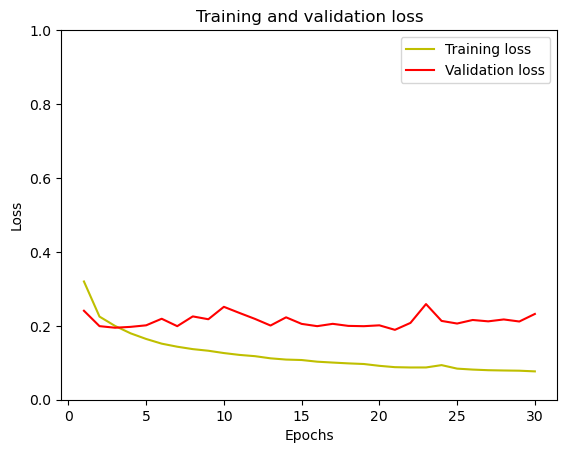

In [138]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.ylim(0, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

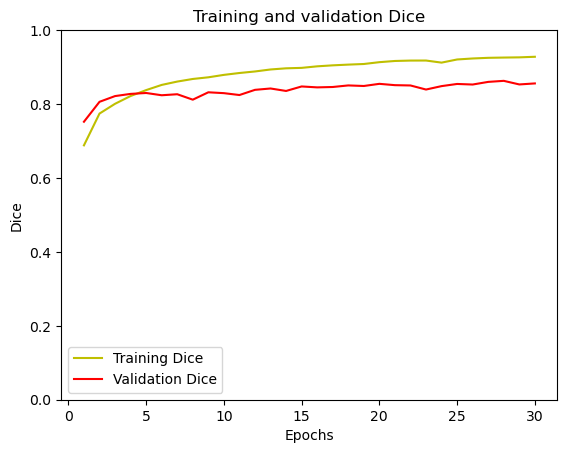

In [139]:
acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.ylim(0, 1)
plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()


In [140]:
model = model_att_unet

In [141]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119


In [142]:
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


1/1 [==============================] - 0s 461ms/step


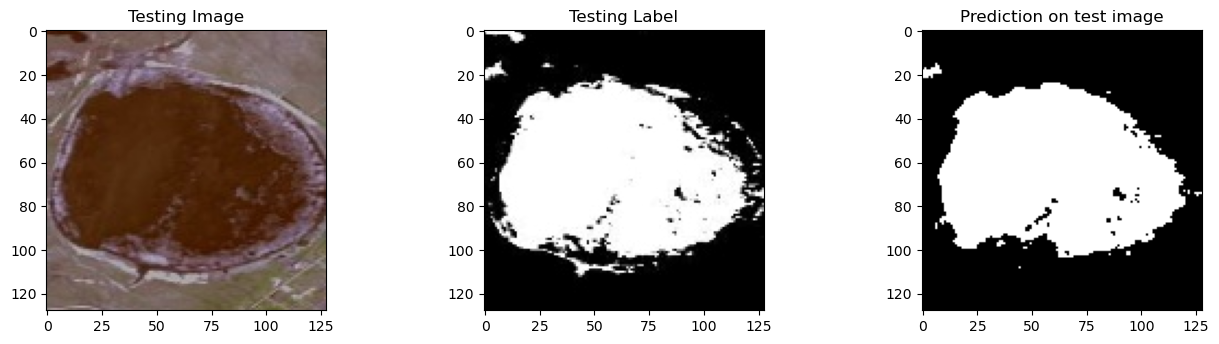

In [143]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


1/1 [==============================] - 0s 22ms/step


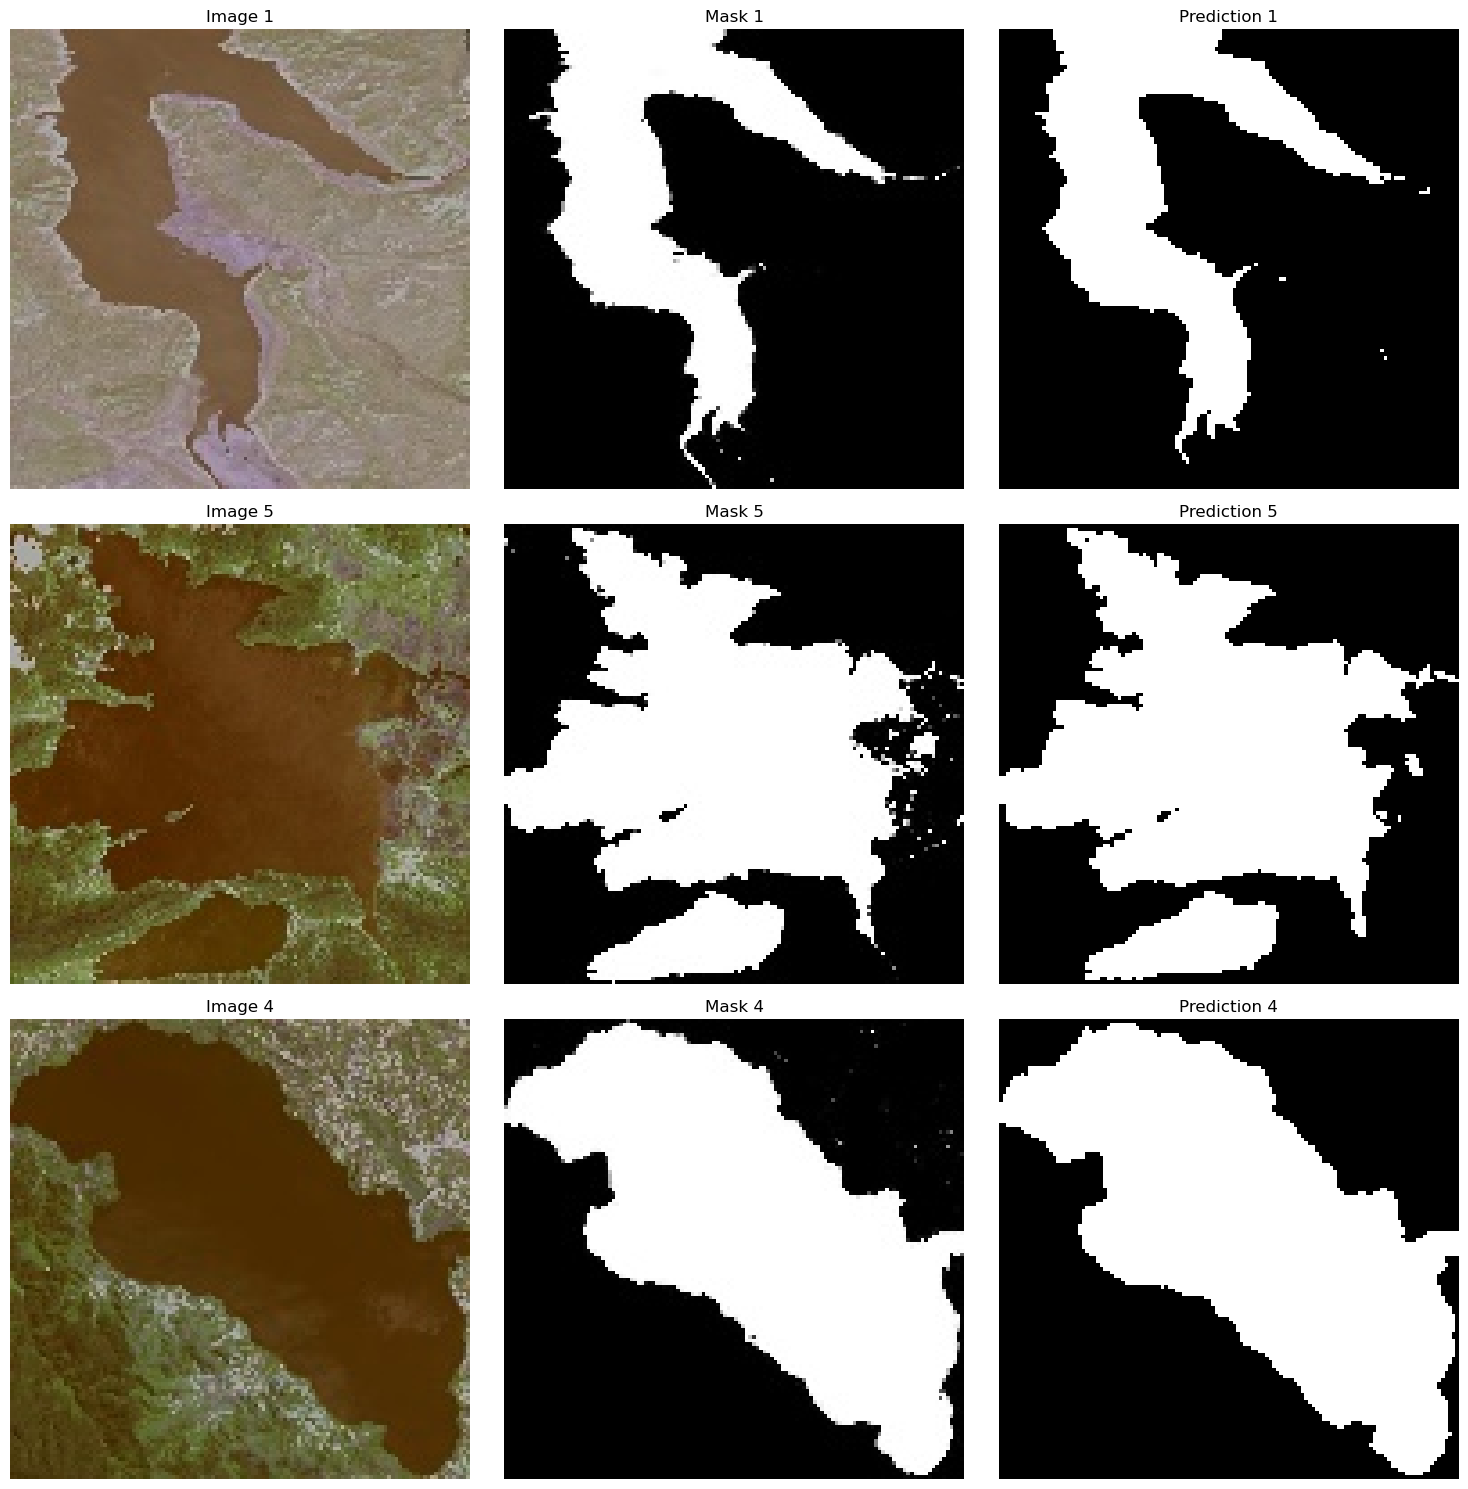

In [144]:
## Choose the number of examples to display
num_examples = 3

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction1 = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


# Randomly select some indices for display
example_indices = [1,5,4]

# Display the selected examples
plt.figure(figsize=(15, 5 * num_examples))

for i, example_index in enumerate(example_indices, 1):
    test_img = X_test[example_index]
    test_img_input=np.expand_dims(test_img, 0)
    prediction1 = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    plt.subplot(num_examples, 3, 3 * i - 2)
    plt.imshow(X_test[example_index])
    plt.title(f"Image {example_index}")
    plt.axis('off')
    
    plt.subplot(num_examples, 3, 3 * i - 1)
    plt.imshow(y_test[example_index], cmap='gray')
    plt.title(f"Mask {example_index}")
    plt.axis('off')

    plt.subplot(num_examples, 3, 3 * i)
    plt.imshow(prediction1, cmap='gray')
    plt.title(f"Prediction {example_index}")
    plt.axis('off')

    
plt.tight_layout()
plt.show()

In [145]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print(" IoU =", IOU_keras.result().numpy())



 IoU = 0.71538067


In [146]:
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    #print(IoU)
    

1/1 [==============================] - 0s 20ms/step


In [147]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    


Mean IoU is:  [0.68232775]
